## Data 604 Final Project: Bicycle Shop Simulation

## Leticia Salazar

## July 17th, 2022

### The problem and its significance. 

The bicycle industry has boomed within the last 2 years of a global pandemic. With bicycles, parts and accessories being scarces sales and repairs have been affected along with unusual wait times, delivery delays and more. This project simulated a 'typical' day at a bicycle shop, the services they provide and wait times pre-pandemic. 

Note: this does not include phone calls and emails from customers and focusing only on in person interactions.

The simulation includes:
* Customer Arrival
* Meet with person working the floor: Depending on the type of service needed the customer will be going into one of three different service areas:
    * Random inquiries: using air pump, questions not related to the business, browsing, etc
    * Sales: looking to buy a bicycle, parts or accessories
        * Special orders: if items are not available some customers may decided to place an order (can take up to 2 days for the order to arrive)
    * Repairs: within this category there's different types of services
        * Short repair: flat fixes, minor adjustments (these usually take anywhere between 10 - 45 minutes)
        * Long repairs: tune-ups, bike assemblies, part replacements, major adjustments (these usually take between 1 hour - 1 business days)
* Normal Exit

For the time being I will be combining Sales and Special orders to be a max time of 60 minutes, Repairs(long and short) to be combined for a max of 75 minutes. All assuming they make a normal exit since in real life, a bicycle shop's simulation would require more time and an additional categories. I have provided a flow chart of what this would look like. I did attempt to make a simulation using the second flow-chart model but being fairly new using Python and SimPy I failed to make a functional model. My attempts are provided on my GitHub(link towards the end)

### Flow-chart model.

The process is shown below diplaying the different options customers have upon arrival and first interaction with floor person.

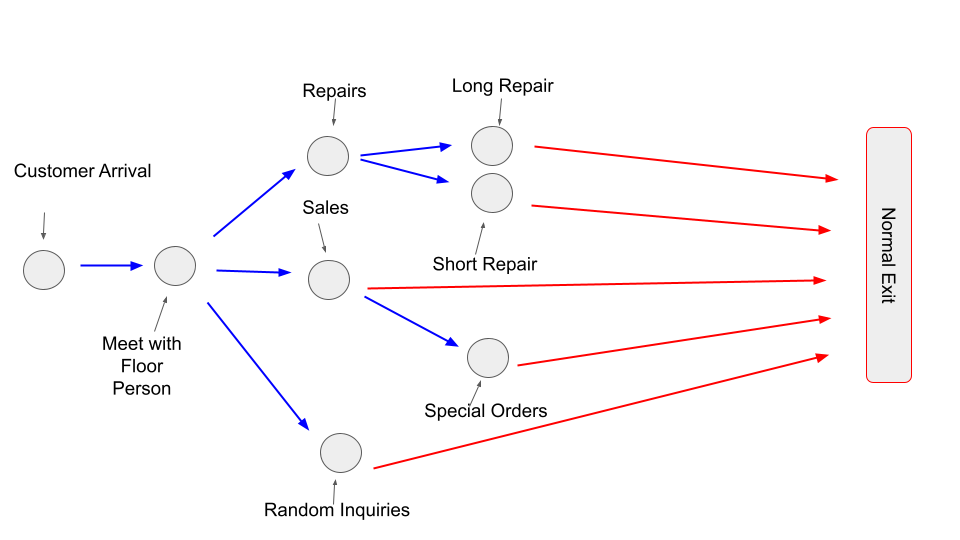

In [1]:
# Bicycle shop model modified and used for this simulation
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/Sim_bike_shop.png', width = 600, height = 700)

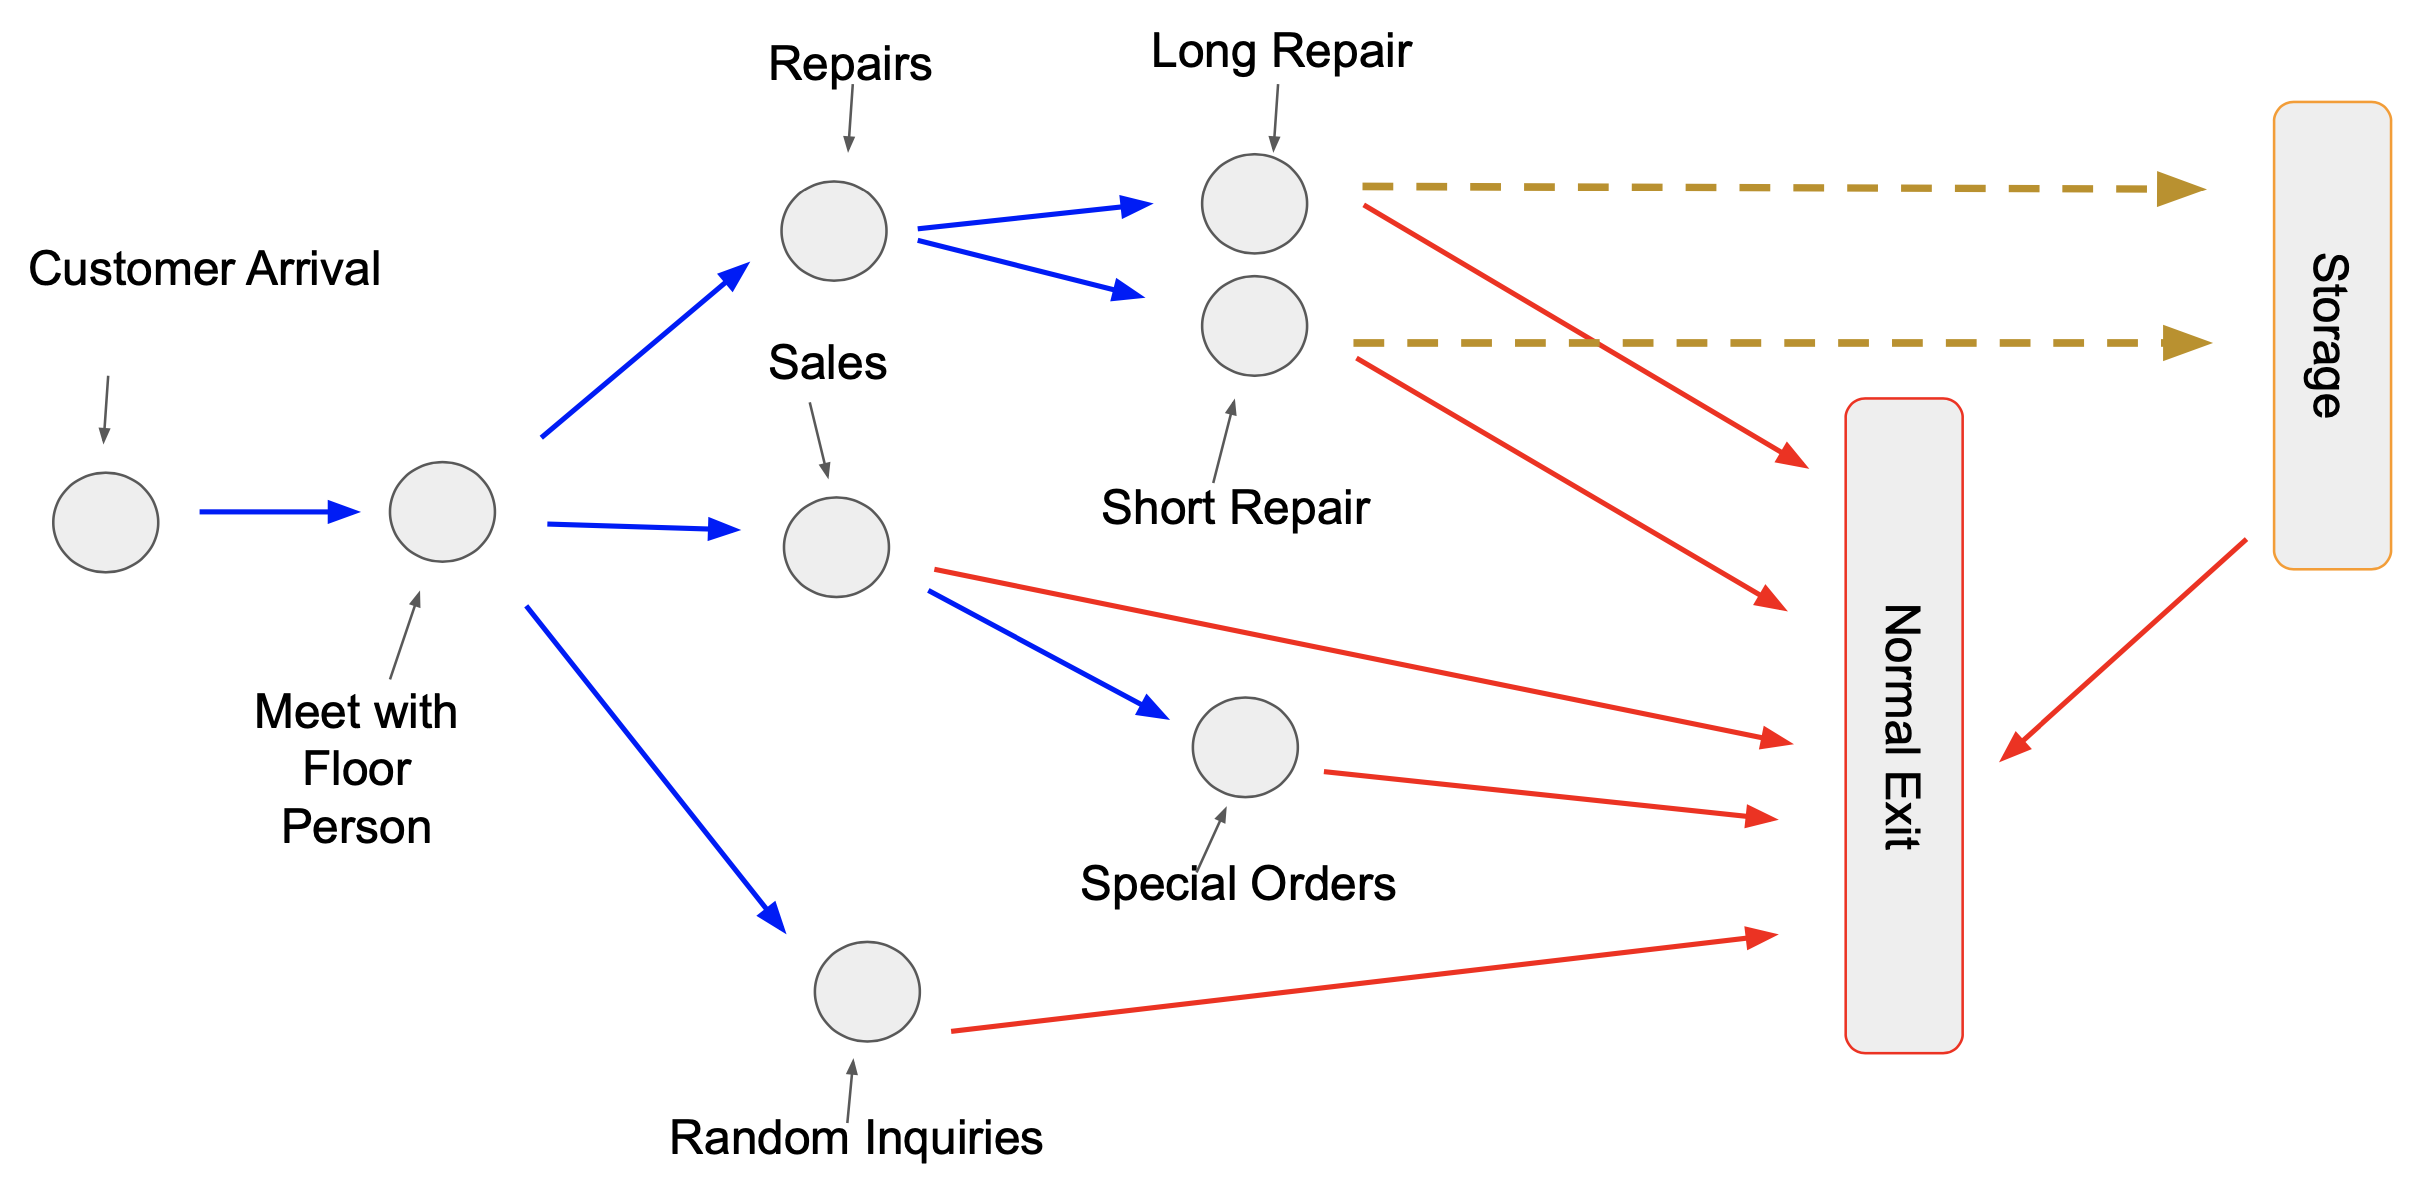

In [2]:
# Bicycle shop model initially intended to use
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/bike_shop_sim.png', width = 600, height = 700)

In [3]:
# Required libraries
import simpy
import numpy as np
import pandas as pd
import random
from modsim import *
import matplotlib.pyplot as plt

In [4]:
# Setting seed and iterations
seed = 55
simulation_time = 8 # operational hours

In [5]:
np.random.seed(seed)

# Creating a data frame to later store data here
df = pd.DataFrame(columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time', 'Service Start Time', 'Service Stop Time'])

In [6]:
# Setting customer arrival every 15 minutes from 2 - 5 customers
def customer_arrival():
    return np.random.exponential(10.0/np.random.randint(2,5))

# Setting time it takes for a customer to meet with floor person     
def meet_floor_person(self, customer):
    # min of 2 minutes and max of 10 minutes
    yield self.env.timeout(random.randint(2, 5))
    
# Setting time it takes for customer to be in repair station
def repair_service():
    return np.random.triangular(10,30,95)

# Setting time it takes for customer to be in sales station
def sales_service():
    return np.random.triangular(5,30,75)

# Setting time it takes for random inqiry to be completed
def random_service():
    return np.random.triangular(2,5,10)

In [7]:
# Defining customer's arrival time to bike shop
def bike_shop(env,  repair, sales, random):
    global current_hour
    
    # Counter for customer's
    i = 0 
    while True:
        Service = np.random.choice(['Repair', 'Sales', 'Random'], p=[0.80, 0.1, 0.1]) 
        i += 1
        yield env.timeout(customer_arrival())
        env.process(customer(env, i,  repair, sales, random, Service))

In [8]:
# Function to generate report for each customer
def customer(env, customer, repair, sales, random, Service):
    
    global df # global variable

    if Service == 'Sales':
        req = sales
    else:
        req = repair
    
    with sales.request() as request:
        arrival_time = env.now # starts the clock
        yield env.timeout(5) # Floor person generation time of 5 minutes
        floor_time = env.now # Records the time a floor person takes with a customer
        
        yield request
        
        # Service starts
        service_start_time = env.now
        
        if Service == 'Sales':
            yield env.timeout(sales_service())
        else:
            yield env.timeout(repair_service())
        service_stop_time = env.now 
        
        # Records the generated data
        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, floor_time, service_start_time, service_stop_time]],
                          columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time','Service Start Time', 'Service Stop Time'])
       
        df = df.append(row, ignore_index = True, sort = False)
        
        # Calculate wait time
        df['Floor Time (Mins)'] = (df['Floor Time'] - df['Arrival Time'])
        df['Service Time (Mins)'] = (df['Service Stop Time'] - df['Service Start Time'])
        df['Wait Time (Mins)'] = (df['Service Start Time'] - df['Floor Time'] )


In [9]:
#Running model
def model(nruns, nrepair, nsales, nrandom): 
    
    # Initializing
    Repair=[] 
    Sales=[]
    Random=[]
    avg_wait_time = []
    sales_wait_time = []
    repair_wait_time = []
    random_wait_time = []
    global df
    for j in range(nruns):
        df = df[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        
        # Assigning parameters as Resource
        repair = simpy.Resource(env, capacity=nrepair) 
        sales = simpy.Resource(env, capacity=nsales) 
        random = simpy.Resource(env, capacity=nrandom) 
        env.process(bike_shop(env, repair, sales, random))
        # Run for 8 ohours
        env.run(until = 8 * 60) 
        
        # Calculating means separately to use later on
        Sales=df[df.Service.isin(['Sales'])] 
        Repair=df[df.Service.isin(['Repair'])]
        Random=df[df.Service.isin(['Random'])]
    
        # Calculating average time
        avg_wait=df['Wait Time (Mins)'].mean() 
        avg_wait_repair=Repair['Wait Time (Mins)'].mean()
        avg_wait_sales=Sales['Wait Time (Mins)'].mean()
        avg_wait_random=Random['Wait Time (Mins)'].mean()
    
        avg_wait_time.append(avg_wait)
        sales_wait_time.append(avg_wait_sales)
        repair_wait_time.append(avg_wait_repair)
        random_wait_time.append(avg_wait_random)
        
    #Save dataframe
    new_dict = {"avg_wait": avg_wait_time, "sales_wait": sales_wait_time, "repair_wait": repair_wait_time, "random_wait": random_wait_time }
    
    global new_data
    new_data = pd.DataFrame(new_dict)
    return new_data

In [10]:
# Tesitng model and checking results
np.random.seed(56)
'''
Model shows 14 operational days with 20 repairs, 
16 sales, and 10 random inquiries
'''
model(14, 20, 16, 10)

,avg_wait,sales_wait,repair_wait,random_wait
0,0.042235,0.195858,0.025780,0.000000
1,1.790983,4.131665,1.654561,0.936063
2,3.783258,4.366715,4.031626,0.567104
3,0.180093,0.733680,0.082062,0.350373
4,9.630450,11.494918,9.829776,6.057351
5,0.009679,0.146566,0.000000,0.000000
6,3.101588,3.248801,3.072176,3.160293
7,1.215796,1.510746,1.209043,0.856229
8,0.000000,0.000000,0.000000,0.000000
9,2.209349,2.263989,2.110199,3.211179


### Justify the validity of the model and discuss how you verified it

The model was verified by trial and error, every time I adjusted the model and ran the simulation I would adjust the numbers in the model() to ensure I was getting good estimates on the waiting times for each service. After many attempts, the output model showing 30 operational days with 24 repairs, 16 sales, and 12 random inquiries indicated a good descriptor of wait times to get a service in a bike shop. To confirm the validity of this simulation is hard, since I do not know of other models out there for bike shops. Again, based on trial and error I was abe to find wait times close enough to reality (basing on my personal experience).

Below I show the data frame with multiple iterations of randomized services performed throughout the 8 hours of operation to show how the simulation performed.

In [11]:
# Showing data frame
df

,Customer Id,Service,Arrival Time,Floor Time,Service Start Time,Service Stop Time,Floor Time (Mins),Service Time (Mins),Wait Time (Mins)
0,Customer_1,Repair,0.827602,5.827602,5.827602,36.239630,5.0,30.412029,0.0
1,Customer_2,Repair,1.460218,6.460218,6.460218,41.688001,5.0,35.227783,0.0
2,Customer_3,Repair,18.031607,23.031607,23.031607,57.525271,5.0,34.493664,0.0
3,Customer_8,Repair,33.726214,38.726214,38.726214,60.079096,5.0,21.352882,0.0
4,Customer_4,Repair,20.885035,25.885035,25.885035,68.270949,5.0,42.385914,0.0
...,...,...,...,...,...,...,...,...,...
108,Customer_111,Sales,419.402834,424.402834,424.402834,465.573185,5.0,41.170351,0.0
109,Customer_118,Repair,451.002898,456.002898,456.002898,473.431836,5.0,17.428938,0.0
110,Customer_110,Repair,414.780941,419.780941,419.780941,476.869877,5.0,57.088936,0.0
111,Customer_113,Repair,425.608045,430.608045,430.608045,477.931794,5.0,47.323749,0.0


Below is a simulation to show how each station in the bicycle shop would run within the first 90 minutes of it's operation hours. I divided up each section separately but initially wanted to define one class, set up each station in that class to be randomized. When the simulation ran it would automatically pick what service the customer 'chose' and keep going until the end of the 8 hour journey.

In [12]:
'''
Setting up repair station process for the bicycle shop. We will start off with 2 bicycles for the 2 mechanics available
and add a bike every 15 minutes. Bicycle repairs take an average of 30 minutes to repair.
'''
RANDOM_SEED = 42
NUM_MECHANICS = 2  # Number of mechanics at the repair station
REPAIR_TIME = 30   # Average time in minutes it takes to repair a bike
T_INTER = 15       # Create a bike every 15 minutes
SIM_TIME = 90     # Simulation time in minutes 


class bike_shop(object):
    def __init__(self, env, num_mechanics, repair_time):
        self.env = env
        self.mechanic = simpy.Resource(env, num_mechanics)
        self.repair_time = repair_time

    def repair(self, bike):
        yield self.env.timeout(REPAIR_TIME)
        print("Mechanic has repaired %d%% of %s's issues." %
              (random.randint(80, 100), bike))

def bike(env, name, rs): # rs stands for repair service
    print('%s arrives at the shop at %.2f.' % (name, env.now))
    with rs.mechanic.request() as request:
        yield request

        print('%s enters the shop at %.2f.' % (name, env.now))
        yield env.process(rs.repair(name))

        print('%s leaves the shop at %.2f.' % (name, env.now))

def setup(env, num_mechanics, repair_time, t_inter):
    # Create the bicycle repair
    bike_repair = bike_shop(env, num_mechanics, repair_time)

    # Create 2 initial bicycles
    for i in range(2):
        env.process(bike(env, 'Bike %d' % i, bike_repair))

    # Create more bicycles while the simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(bike(env, 'Bike %d' % i, bike_repair))

# Setup and start the simulation
print('bike_shop')
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_MECHANICS, REPAIR_TIME, T_INTER))

# Execute!
env.run(until = SIM_TIME)

bike_shop
Bike 0 arrives at the shop at 0.00.
Bike 1 arrives at the shop at 0.00.
Bike 0 enters the shop at 0.00.
Bike 1 enters the shop at 0.00.
Bike 2 arrives at the shop at 13.00.
Bike 3 arrives at the shop at 26.00.
Mechanic has repaired 87% of Bike 0's issues.
Mechanic has repaired 87% of Bike 1's issues.
Bike 0 leaves the shop at 30.00.
Bike 1 leaves the shop at 30.00.
Bike 2 enters the shop at 30.00.
Bike 3 enters the shop at 30.00.
Bike 4 arrives at the shop at 41.00.
Bike 5 arrives at the shop at 55.00.
Mechanic has repaired 97% of Bike 2's issues.
Mechanic has repaired 82% of Bike 3's issues.
Bike 2 leaves the shop at 60.00.
Bike 3 leaves the shop at 60.00.
Bike 4 enters the shop at 60.00.
Bike 5 enters the shop at 60.00.
Bike 6 arrives at the shop at 68.00.
Bike 7 arrives at the shop at 85.00.


In [13]:
'''
Setting up sales station process for the bicycle shop. We will start off with 1 customer in the shop for the 1 sales
rep with a customer coming in for a sale every 20 minutes. 
'''

RANDOM_SEED = 32
NUM_SALES_REP = 1  # Number of sales reps at the station
SALES_TIME = 15   # Average time in minutes it takes to make a sale
T_INTER = 20      # Create a sale every 20 minutes
SIM_TIME = 90     # Simulation time in minutes 


class bike_shop(object):
    def __init__(self, env, num_sales_rep, sales_time):
        self.env = env
        self.sales_rep = simpy.Resource(env, num_sales_rep)
        self.sales_time = sales_time

    def sales(self, customer):
        yield self.env.timeout(SALES_TIME)
        print("The sales rep taken care of %d%% of %s's sales needs." %
              (random.randint(90, 100), customer))

def customer(env, name, s): # s stands for sale
    print('%s arrives at the shop at %.2f.' % (name, env.now))
    with s.sales_rep.request() as request:
        yield request

        print('%s enters the shop at %.2f.' % (name, env.now))
        yield env.process(s.sales(name))

        print('%s leaves the shop at %.2f.' % (name, env.now))

def setup(env, num_sales_rep, sales_time, t_inter):
    # Create the sales
    sold = bike_shop(env, num_sales_rep, sales_time)

    # Create 1 initial sales
    for i in range(1):
        env.process(customer(env, 'Customer %d' % i, sold))

    # Create more bicycles while the simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(customer(env, 'Customer %d' % i, sold))

# Setup and start the simulation
print('bike_shop')
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_SALES_REP, SALES_TIME, T_INTER))

# Execute!
env.run(until = SIM_TIME)

bike_shop
Customer 0 arrives at the shop at 0.00.
Customer 0 enters the shop at 0.00.
The sales rep taken care of 93% of Customer 0's sales needs.
Customer 0 leaves the shop at 15.00.
Customer 1 arrives at the shop at 18.00.
Customer 1 enters the shop at 18.00.
The sales rep taken care of 94% of Customer 1's sales needs.
Customer 1 leaves the shop at 33.00.
Customer 2 arrives at the shop at 37.00.
Customer 2 enters the shop at 37.00.
The sales rep taken care of 97% of Customer 2's sales needs.
Customer 2 leaves the shop at 52.00.
Customer 3 arrives at the shop at 56.00.
Customer 3 enters the shop at 56.00.
The sales rep taken care of 90% of Customer 3's sales needs.
Customer 3 leaves the shop at 71.00.
Customer 4 arrives at the shop at 74.00.
Customer 4 enters the shop at 74.00.
The sales rep taken care of 95% of Customer 4's sales needs.
Customer 4 leaves the shop at 89.00.


In [14]:
'''
Setting up random inquiry station process for the bicycle shop. We will start off with 2 customer in the shop with a 
customer coming in with a random inquiry every 10 minutes. 
'''

RANDOM_SEED = 22
NUM_FLOOR_PERSON = 1  # Number of people on the floor at the station
RANDOM_INQ_TIME = 5   # Average time in minutes for the random inqury to take place
T_INTER = 10      # Create a random inqury every 10 minutes
SIM_TIME = 90     # Simulation time in minutes 


class bike_shop(object):
    def __init__(self, env, num_floor_person, random_inq_time):
        self.env = env
        self.floor_person = simpy.Resource(env, num_floor_person)
        self.random_inq_time = random_inq_time

    def random_inq(self, person):
        yield self.env.timeout(SALES_TIME)
        print("The floor person taken care of %d%% of %s's questions." %
              (random.randint(95, 100), person))

def person(env, name, ri): # ri stands for random inquiry
    print('%s arrives at the shop at %.2f.' % (name, env.now))
    with ri.floor_person.request() as request:
        yield request

        print('%s enters the shop at %.2f.' % (name, env.now))
        yield env.process(ri.random_inq(name))

        print('%s leaves the shop at %.2f.' % (name, env.now))

def setup(env, num_floor_person, random_inq_time, t_inter):
    # Create the sales
    random_inq = bike_shop(env, num_floor_person, random_inq_time)

    # Create 1 initial random inquiries
    for i in range(1):
        env.process(person(env, 'Person %d' % i, random_inq))

    # Create more bicycles while the simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(person(env, 'Person %d' % i, random_inq))

# Setup and start the simulation
print('bike_shop')
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_FLOOR_PERSON, RANDOM_INQ_TIME, T_INTER))

# Execute!
env.run(until = SIM_TIME)

bike_shop
Person 0 arrives at the shop at 0.00.
Person 0 enters the shop at 0.00.
Person 1 arrives at the shop at 9.00.
The floor person taken care of 95% of Person 0's questions.
Person 0 leaves the shop at 15.00.
Person 1 enters the shop at 15.00.
Person 2 arrives at the shop at 18.00.
The floor person taken care of 98% of Person 1's questions.
Person 3 arrives at the shop at 30.00.
Person 1 leaves the shop at 30.00.
Person 2 enters the shop at 30.00.
Person 4 arrives at the shop at 39.00.
The floor person taken care of 100% of Person 2's questions.
Person 2 leaves the shop at 45.00.
Person 3 enters the shop at 45.00.
Person 5 arrives at the shop at 47.00.
Person 6 arrives at the shop at 57.00.
The floor person taken care of 96% of Person 3's questions.
Person 3 leaves the shop at 60.00.
Person 4 enters the shop at 60.00.
Person 7 arrives at the shop at 65.00.
The floor person taken care of 95% of Person 4's questions.
Person 8 arrives at the shop at 75.00.
Person 4 leaves the shop a

### Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues. 

Box plot below shows the results of my model showing the average wait time in general, for sales, repair and random inquiry. As seen in the figure, the averages for all wait times fall between 0 - 1.5 minutes with a couple of outliers in avg wait, sales and repairs ranging between 9 - 12 mins.

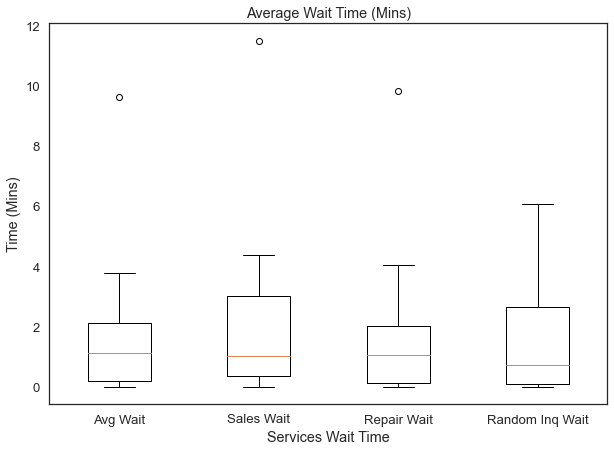

In [15]:
# Boxplot of new_data 
fig = plt.figure(figsize = (10, 7))

 
# Creating plot and labeling axis
plt.boxplot(new_data)
plt.title('Average Wait Time (Mins)')
plt.ylabel('Time (Mins)')
plt.xlabel('Services Wait Time')
plt.xticks([1,2,3,4], ['Avg Wait', 'Sales Wait', 'Repair Wait', 'Random Inq Wait'])

# Save fig
fig.savefig('boxplot_new_data_avg_wait.png')

plt.show()

The histogram below is showing the data's frequency distribution for wait time in minutes. Based on this figure, about 120 customer have a wait time of 0 - 1.5 minutes and less than 10 customers wait around 2 - 13 minutes for a service.

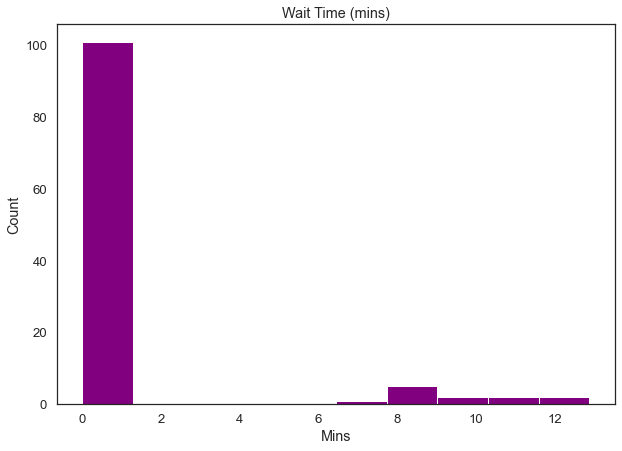

In [16]:
# Histogram of wait time in minutes
fig = plt.figure(figsize = (10,7))
plt.hist(df['Wait Time (Mins)'], color = 'purple')
plt.title('Wait Time (mins)')
plt.xlabel('Mins')
plt.ylabel('Count')

# Save fig
fig.savefig('hist_wait_time_mins.png')

plt.show()

The histogram below shows the new_data average wait also showing the majority of customers wait 0 - 4 minutes and a couple waiting between 8 - 10 minutes.

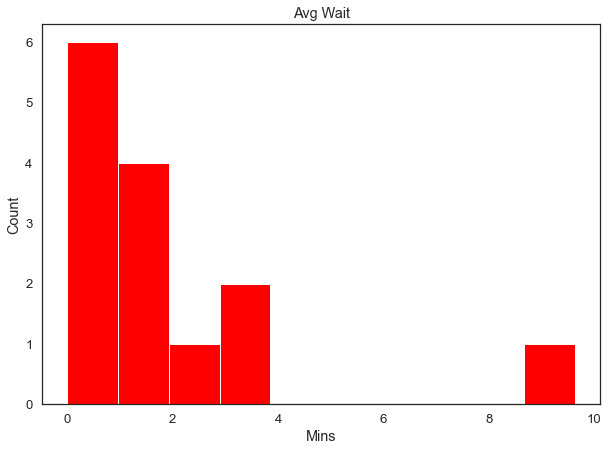

In [17]:
# Histogram of wait time in minutes
fig = plt.figure(figsize = (10,7))
plt.hist(new_data['avg_wait'], color = 'red')
plt.title('Avg Wait')
plt.xlabel('Mins')
plt.ylabel('Count')

# Save fig
fig.savefig('hist_new_data_avg_wait.png')

plt.show()

Below is a line plot for the data looking into the Service Time in minutes.

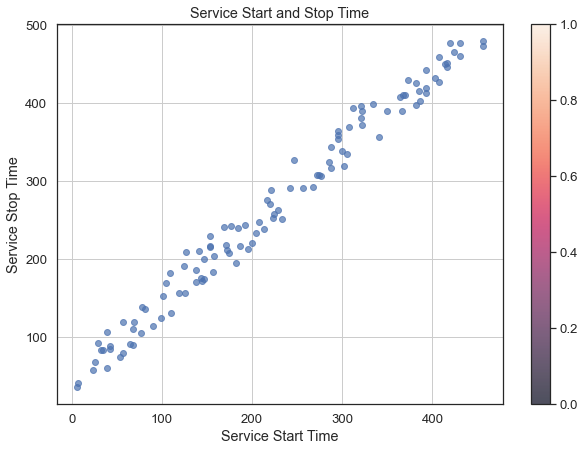

In [39]:
# Line plot of wait times in minutes
fig = plt.figure(figsize = (10,7))
plt.scatter('Service Start Time', 'Service Stop Time', data = df, alpha = 0.7, cmap = 'gnuplot2')
#plt.plot(df['Service Time (Mins)'], color = 'green')
#plt.axvline(x = np.mean('Service Time (Mins), color = 'r', linestyle = 'dashed', label = 'axvline - full height')
plt.title('Service Start and Stop Time')
plt.ylabel('Service Stop Time')
plt.xlabel('Service Start Time')
cb= plt.colorbar()
plt.grid(True)

# Save fig
fig.savefig('scatter_service.png')

plt.show()

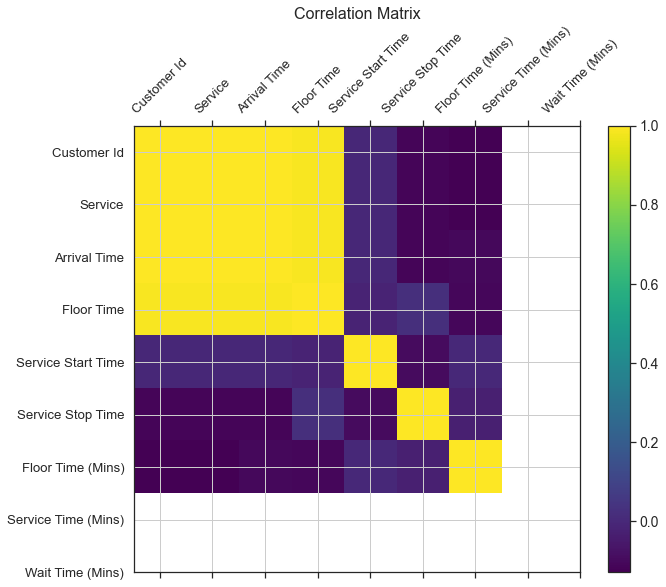

In [40]:
f = plt.figure(figsize = (10, 8))
plt.matshow(df.corr(), fignum=f.number,cmap ='viridis')
plt.xticks(range(9),df.columns, rotation=45) 
plt.yticks(range(9),df.columns) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.grid(True)
plt.title('Correlation Matrix', fontsize=16);

### State  your conclusions / findings from the model. 

Based on my model the average wait time to get a service is less than 1 minute. Majority of the customers that come in to the shop wait no more than 6 minutes to get serviced.

My model also showed some missing values for wait times for random inquiries which I found odd but looking back at my code I realized I removed the random_service out from the for loop because I kept getting errors. The errors coud have been because I wasn't placing the random inquiries properly in the for loop. After adjusting my model one more time I was able to get the wait time averages (shown below) for each service. 

With more experience or more time working on this simulation I could have improved it more and probably figure out what is wrong with my original code that didn't pan out as I wished.

In [19]:
# Print out the Averages calculated

print('Avg wait:', df['Wait Time (Mins)'].mean())

Sales = df[df.Service.isin(['Sales'])]
print('Avg time for a customer going for sales to wait is:',Sales['Wait Time (Mins)'].mean())

Repair = df[df.Service.isin(['Repair'])]
print('Avg time for a customer going for repair to wait is:',Repair['Wait Time (Mins)'].mean())

Random = df[df.Service.isin(['Random'])]
print('Avg time for a customer going for random inqury to wait is:',Random['Wait Time (Mins)'].mean())

Avg wait: 1.0398000729788297
Avg time for a customer going for sales to wait is: 0.9465665273073983
Avg time for a customer going for repair to wait is: 0.8979364502079632
Avg time for a customer going for random inqury to wait is: 3.0699190305533244


In [20]:
#new_data['avg_wait'].plot.bar(figsize = (10,7))
#Out of 22 days, average wait time exceeded 10 mins on 2 days. This is less than 10% of the time.

### References and Links:

GitHub: https://github.com/letisalba/Data-604/tree/master/Week_7 here you can explore my attempts to run this simulation.

Code Credit: https://rpubs.com/zahirf after doing some code search I came across this person's code in rpubs. With some modifications I was able to run this simulation properly and hoping to continue to study it further to improve my coding skills.
